⚡ Using mps
📂 Train: 5710 | Test: 1309 | Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
🚀 Loading EfficientNet-B7
[HeadOnly Epoch 1] TrainAcc=0.5655, TestAcc=0.7624, TrainLoss=1.0651, TestLoss=0.8078, F1=0.7538
💾 New Best Saved: checkpoints_b7/head.pth with F1=0.7538
[HeadOnly Epoch 2] TrainAcc=0.6308, TestAcc=0.7571, TrainLoss=0.9503, TestLoss=0.8270, F1=0.7503
[HeadOnly Epoch 3] TrainAcc=0.6476, TestAcc=0.8075, TrainLoss=0.9178, TestLoss=0.7795, F1=0.7940
💾 New Best Saved: checkpoints_b7/head.pth with F1=0.7940
[HeadOnly Epoch 4] TrainAcc=0.6583, TestAcc=0.7869, TrainLoss=0.9161, TestLoss=0.7751, F1=0.7770
[HeadOnly Epoch 5] TrainAcc=0.6639, TestAcc=0.7846, TrainLoss=0.8932, TestLoss=0.7833, F1=0.7771
[LastBlock Epoch 1] TrainAcc=0.6737, TestAcc=0.7937, TrainLoss=0.8651, TestLoss=0.7991, F1=0.7834
💾 New Best Saved: checkpoints_b7/lastblock.pth with F1=0.7834
[LastBlock Epoch 2] TrainAcc=0.6918, TestAcc=0.7884, TrainLoss=0.8535, TestLoss=0.8315, F1=0.7647
[LastBlock Epoch 3

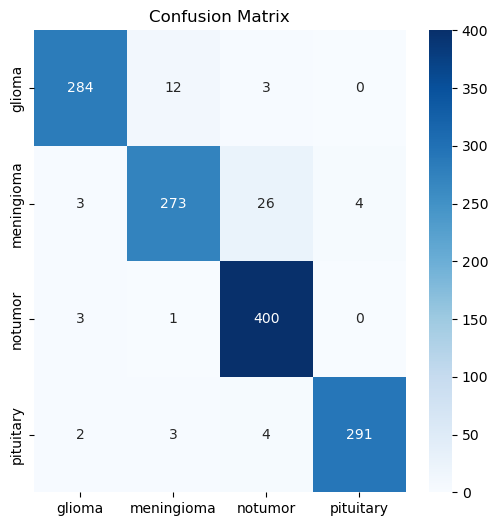

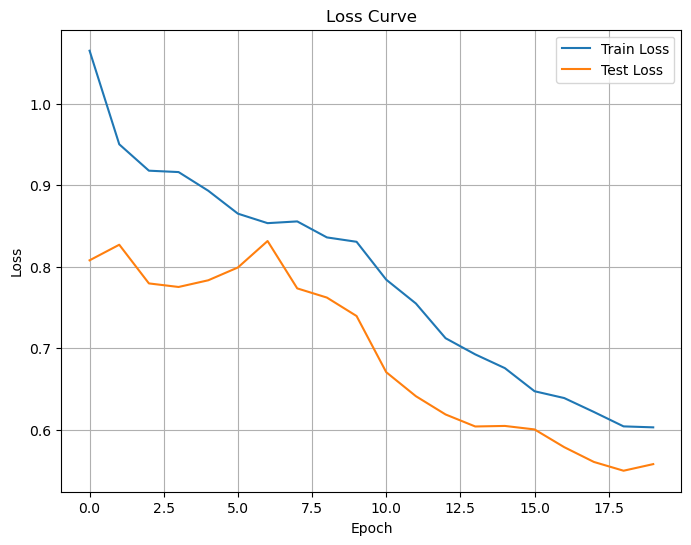

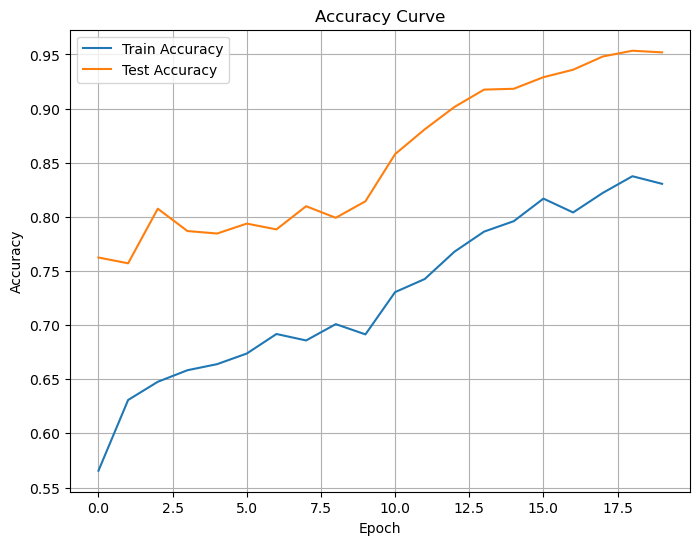

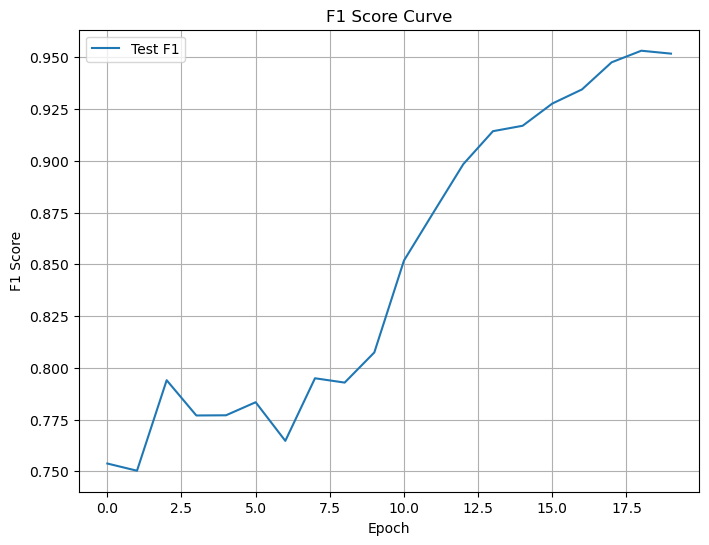

In [1]:
import os, warnings, logging, random
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

# =====================
# SETTINGS
# =====================
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
logger.info(f"⚡ Using {DEVICE}")

BATCH_SIZE = 2           # safe on MPS
ACCUM_STEPS = 8          # simulate larger batch
IMG_SIZE = 300           # safe resolution
PATIENCE = 5
MIXUP_PROB = 0.5
CHECKPOINT_DIR = "checkpoints_b7"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

TRAIN_DIR = r'/Users/muhammadmuhtasimshahriar/Downloads/archive/Training'
TEST_DIR  = r'/Users/muhammadmuhtasimshahriar/Downloads/archive/Testing'

# =====================
# DATA TRANSFORMS
# =====================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# =====================
# DATASETS
# =====================
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=test_transform)
num_classes = len(train_dataset.classes)

logger.info(f"📂 Train: {len(train_dataset)} | Test: {len(test_dataset)} | Classes: {train_dataset.classes}")

# Balanced sampler
class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / class_counts
samples_weight = [class_weights[t] for t in train_dataset.targets]
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# =====================
# MODEL
# =====================
logger.info("🚀 Loading EfficientNet-B7")
model = models.efficientnet_b7(weights="IMAGENET1K_V1")
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes)
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
model = model.to(DEVICE)

# =====================
# MixUp
# =====================
def mixup_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    return mixed_x, y, y[index], lam

def mixup_loss(pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# =====================
# EVALUATION
# =====================
def evaluate(model):
    model.eval()
    y_true, y_pred = [], []
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    f1 = f1_score(y_true, y_pred, average="macro")
    return acc, total_loss/len(test_loader), f1, y_true, y_pred

# =====================
# TRAIN FUNCTION
# =====================
history = {"train_acc": [], "test_acc": [], "train_loss": [], "test_loss": [], "f1": []}

def train_model(model, optimizer, scheduler, epochs, phase_name, ckpt_file):
    best_f1 = 0
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        optimizer.zero_grad()
        
        for step,(imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            if random.random() < MIXUP_PROB and imgs.size(0) > 1:
                imgs, y_a, y_b, lam = mixup_data(imgs, labels)
                outputs = model(imgs)
                loss = mixup_loss(outputs, y_a, y_b, lam) / ACCUM_STEPS
            else:
                outputs = model(imgs)
                loss = criterion(outputs, labels) / ACCUM_STEPS

            loss.backward()
            if (step+1) % ACCUM_STEPS == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item() * ACCUM_STEPS
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = total_loss / len(train_loader)
        test_acc, test_loss, test_f1, _, _ = evaluate(model)

        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["f1"].append(test_f1)

        scheduler.step(test_f1)

        logger.info(f"[{phase_name} Epoch {epoch+1}] "
                    f"TrainAcc={train_acc:.4f}, TestAcc={test_acc:.4f}, "
                    f"TrainLoss={train_loss:.4f}, TestLoss={test_loss:.4f}, "
                    f"F1={test_f1:.4f}")

        if test_f1 > best_f1:
            best_f1 = test_f1
            torch.save(model.state_dict(), ckpt_file)
            patience_counter = 0
            logger.info(f"💾 New Best Saved: {ckpt_file} with F1={best_f1:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                logger.info("⏹ Early stopping")
                break

    return ckpt_file

# =====================
# TRAINING PHASES
# =====================
# Phase 1: Head Only
for p in model.features.parameters(): p.requires_grad = False
opt = optim.Adam(model.classifier.parameters(), lr=1e-3)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, "max", patience=2, factor=0.3)
train_model(model, opt, sched, epochs=5, phase_name="HeadOnly", ckpt_file=os.path.join(CHECKPOINT_DIR,"head.pth"))

# Phase 2: Last Block
for p in model.features[-1].parameters(): p.requires_grad = True
opt = optim.Adam([
    {"params": model.features[-1].parameters(), "lr": 1e-5},
    {"params": model.classifier.parameters(), "lr": 5e-4}
])
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, "max", patience=2, factor=0.3)
train_model(model, opt, sched, epochs=5, phase_name="LastBlock", ckpt_file=os.path.join(CHECKPOINT_DIR,"lastblock.pth"))

# Phase 3: Full Fine-tune (can be run in chunks)
for p in model.parameters(): p.requires_grad = True
opt = optim.Adam(model.parameters(), lr=1e-5)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, "max", patience=3, factor=0.3)
train_model(model, opt, sched, epochs=10, phase_name="FullFT_chunk1", ckpt_file=os.path.join(CHECKPOINT_DIR,"fullft1.pth"))
# repeat with load_state_dict(torch.load("fullft1.pth")) for more chunks

# =====================
# FINAL EVAL
# =====================
model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR,"fullft1.pth")))
final_acc, final_loss, final_f1, y_true, y_pred = evaluate(model)

final_prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
final_rec = recall_score(y_true, y_pred, average="macro", zero_division=0)

logger.info("\n📊 FINAL RESULTS")
logger.info("=============================")
logger.info(f"✅ Accuracy         : {final_acc*100:.2f}%")
logger.info(f"🎯 Precision (Macro): {final_prec:.4f}")
logger.info(f"📌 Recall    (Macro): {final_rec:.4f}")
logger.info(f"📈 F1-Score  (Macro): {final_f1:.4f}")

# =====================
# CONFUSION MATRIX
# =====================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# =====================
# TRAINING CURVES
# =====================
plt.figure(figsize=(8,6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["test_loss"], label="Test Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,6))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Accuracy Curve"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,6))
plt.plot(history["f1"], label="Test F1")
plt.xlabel("Epoch"); plt.ylabel("F1 Score")
plt.title("F1 Score Curve"); plt.legend(); plt.grid(True); plt.show()

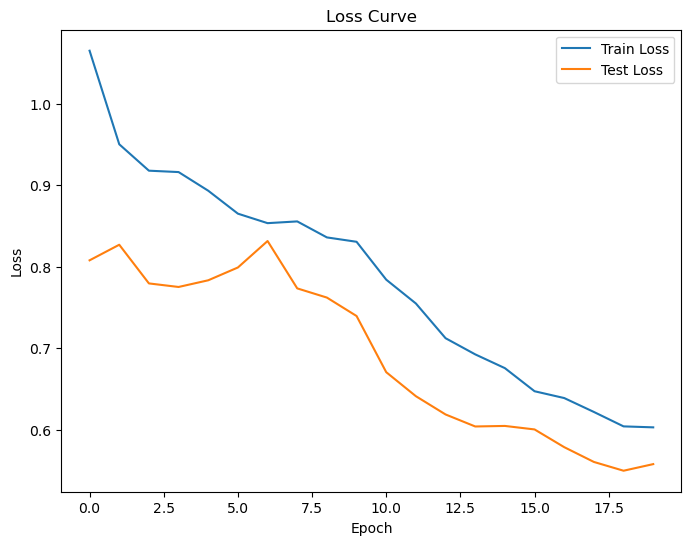

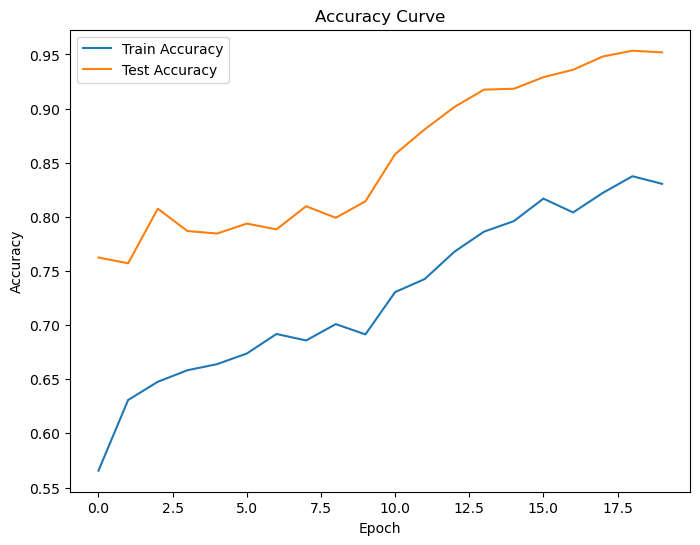

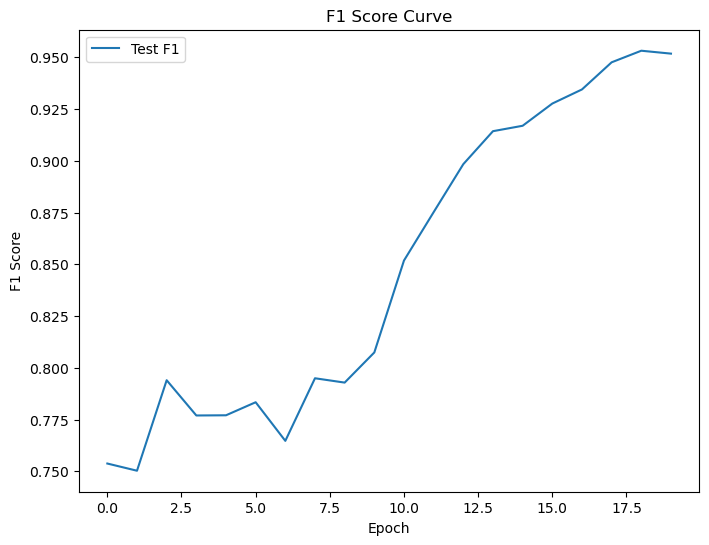

In [2]:
# =====================
# TRAINING CURVES
# =====================
plt.figure(figsize=(8,6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["test_loss"], label="Test Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss Curve"); plt.legend(); plt.show()

plt.figure(figsize=(8,6))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Accuracy Curve"); plt.legend();  plt.show()

plt.figure(figsize=(8,6))
plt.plot(history["f1"], label="Test F1")
plt.xlabel("Epoch"); plt.ylabel("F1 Score")
plt.title("F1 Score Curve"); plt.legend();  plt.show()